In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import random

random.seed(15)

words = open('names.txt', 'r').read().splitlines()
random.shuffle(words)

In [3]:
all_characters = sorted(set(''.join(words)))
stoi = {char: index + 1 for index, char in enumerate(all_characters)}
stoi['.'] = 0
itos = { char: index for index, char in stoi.items()}

In [4]:
# neural network parameters for modification
context_size = 3
embedding_dimensions = 2
second_layer_neurons = 100
batch_size = 48
training_set_iterations = 10000

In [5]:
# nn architecture

g = torch.Generator().manual_seed(3498561551) # for reproducibility
C = torch.randn((27, embedding_dimensions), requires_grad=True, generator=g)
W1 = torch.randn((context_size * embedding_dimensions, second_layer_neurons), requires_grad=True, generator=g)
b1 = torch.randn(second_layer_neurons, requires_grad=True, generator=g)
W2 = torch.randn((second_layer_neurons, 27), requires_grad=True, generator=g)
b2 = torch.randn(27, requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

In [6]:

def build_dataset(words):
    X, Y = [], []

    for word in words:
        context = [0] * context_size
        for char in word + '.':
            ichar = stoi[char]
            X.append(context)
            Y.append(ichar)
            # print(''.join(itos[i] for i in context), '-->', char)
            context = context[1:] + [ichar]

    return torch.tensor(X), torch.tensor(Y)

Xtr, Ytr = build_dataset(words[:int(0.8*len(words))])
Xdev, Ydev = build_dataset(words[int(0.8*len(words)):int(0.9*len(words))])
Xte, Yte = build_dataset(words[int(0.9*len(words)):])

print(len(words))
Xtr.size(), Xdev.size(), Xte.size()


32033


(torch.Size([182465, 3]), torch.Size([22863, 3]), torch.Size([22818, 3]))

In [7]:
pn = sum(p.nelement() for p in parameters)
print('Number of parameters:', pn)

Number of parameters: 3481


In [8]:
learning_rate = torch.linspace(0.4, 0.001, training_set_iterations)

In [9]:
# training set
lossi = []
iteration = []

for i in range(training_set_iterations):
    batch = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xbatch = Xtr[batch]
    Ybatch = Ytr[batch]

    embedding = C[Xbatch]
    x = torch.tanh(embedding.view(Xbatch.shape[0], 6) @ W1 + b1)
    logits = x @ W2 + b2
    loss = F.cross_entropy(logits, Ybatch)

    for p in parameters:
        p.grad = None
    loss.backward()

    for p in parameters:
        p.data += -learning_rate[i] * p.grad
    
    lossi.append(loss.item())
    iteration.append(i)


In [10]:
# test set

embedding = C[Xte]
x = torch.tanh(embedding.view(Xte.shape[0], 6) @ W1 + b1)
logits = x @ W2 + b2
loss = F.cross_entropy(logits, Yte)

for p in parameters:
    p.grad = None
loss.backward()

for p in parameters:
    p.data += -0.01 * p.grad



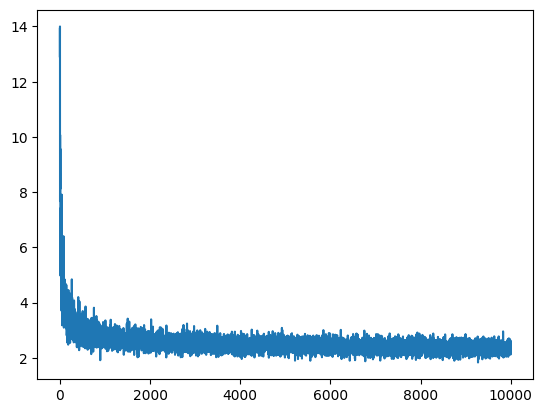

In [11]:
plt.plot(iteration, lossi)

In [12]:
def calculate_loss(X, Y):
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(X.shape[0], context_size * embedding_dimensions) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    return loss.item()

print('Training set loss: ', calculate_loss(Xtr, Ytr))
print('Development set loss: ', calculate_loss(Xdev, Ydev))

Training set loss:  2.3383824825286865
Development set loss:  2.349829912185669
